In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
import scipy.ndimage as nd

# Building a Gaussian Random Field

David Kirkby put together a very nice investigation of [Fringing in Astronomical CCDs](https://github.com/dkirkby/AstroCCD/blob/master/Fringing.ipynb). As part of his study, he simulates variations in the surface heights of CCDs with Gaussian random fields (GRFs). I am rather new to this subject, so I put together this notebook to improve my physical understanding of GRFs (this might also help me understand the matter power spectrum in cosmology). hello wolrd

We are eventually building a random sampling of a power spectrum of the form:

$p(k) = (\frac{k}{k_0})^\alpha  \times e^{-k^2/k_0^2} \times \mathcal{N} \times e^{i \phi}$

Here we have defined:
* $k$: the wavenumber, which `numpy` defines as $\frac{1}{x}$
* $\alpha$: a power-law exponent; $\alpha > 0$ enhances small spatial scales, while $\alpha < 0$ supresses them (we define `kpow` $= \frac{\alpha}{2}$)
* $k_0$: a characteristic scale for exponential suppression and power-law enhancement/suppression.
* $\phi$: a random phase chosen uniformly from $U(0,2\pi)$
* $\mathcal{N}$: a random value chosen from the normal distribution with $\mathcal{N}(\mu=0, \sigma=1)$


To gain some physical intuition, we slowly build up this full power spectrum from it's individual pieces. We also make a few simplifying assumptions:
* The spatial dimensions are equal ($n = n_x = n_y$)
* We fix the random seed to always be the same

In [2]:
# Random seed
seed = 123

# Spatial dimension
n = nx = ny = 512

# Exponential scale length
#k0 = kvec[n // 2]
k0 = 0.5

# Power law suppression
#fractal_dimension = 2.5
#H = 1 - (fractal_dimension - 2)
#kpow = -(H + 1.0) / 2.0
alpha = -1.5
kpow = alpha/2.

In [3]:
#xx,yy = np.meshgrid(np.arange(nx),np.arange(ny), sparse=True, copy=False)
xx,yy = np.meshgrid(np.arange(nx),np.arange(ny), sparse=False, copy=False)

# Frequency space
kvec = np.fft.fftfreq(n)

# Create a 2D grid of wavenumber
#kx, ky = np.meshgrid(kvec, kvec, sparse=True, copy=False)
kx, ky = np.meshgrid(kvec, kvec, sparse=True, copy=False)
ksq = kx ** 2 + ky ** 2

# Only ksq[0,0] == 0
m = ksq > 0

# Generate random numbers
gen = np.random.RandomState(seed=seed)
phase = 2 * np.pi * gen.uniform(size=(n,n))
norm = gen.normal(size=(n,n))

First we start with a power spectrum of the form:

$p(k) = \mathcal{N} \times e^{i \phi}$

In [4]:
# Create the random field in k-space
rand = norm * np.exp(1.j * phase)
func = lambda ksq: np.ones_like(ksq)
kA = rand * func(ksq)
xA = np.fft.ifft2(kA)

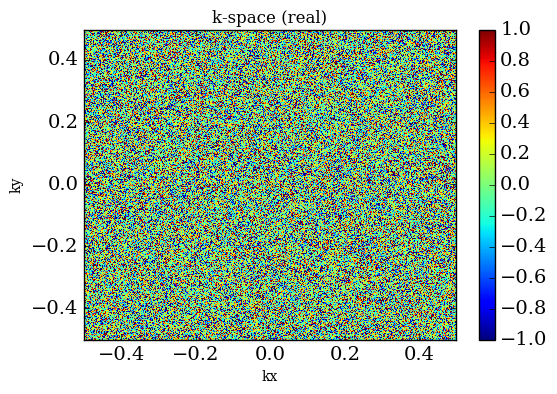

In [5]:
# fftfreq doesn't sort output, so hard to plot
def plot_kspace(kx,ky,kA, **kwargs):    
    kwargs.setdefault('vmin',-1)
    kwargs.setdefault('vmax',1)
    
    skx = np.argsort(kx,axis=1)
    sky = np.argsort(ky,axis=0)

    fig = plt.gcf(); ax = plt.gca()
    im = ax.pcolormesh(kx[0,skx],ky[sky],kA[skx,sky].real,**kwargs); plt.colorbar(im, ax=ax);
    ax.set_title("k-space (real)")
    ax.set_xlim(kx.min(),kx.max()); ax.set_ylim(ky.min(),ky.max())
    plt.xlabel('kx'); plt.ylabel('ky')
    
plot_kspace(kx,ky,kA)

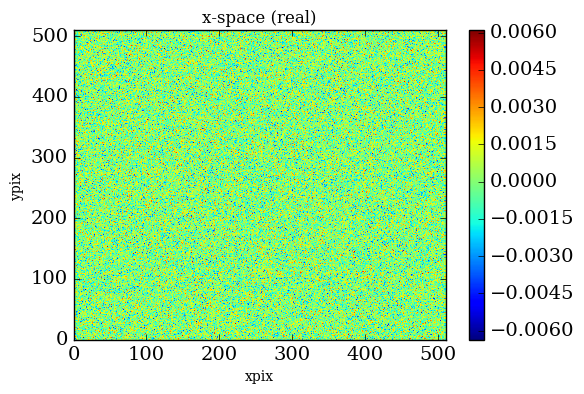

In [6]:
def plot_xspace(xx,yy,xA, **kwargs):
    fig = plt.gcf(); ax = plt.gca()
    im = ax.pcolormesh(xx,yy,xA.real,**kwargs); plt.colorbar(im, ax=ax)
    ax.set_xlim(xx.min(),xx.max()); ax.set_ylim(yy.min(),yy.max())
    ax.set_title("x-space (real)")
    ax.set_xlabel('xpix'); ax.set_ylabel('ypix')

plot_xspace(xx,yy,xA)

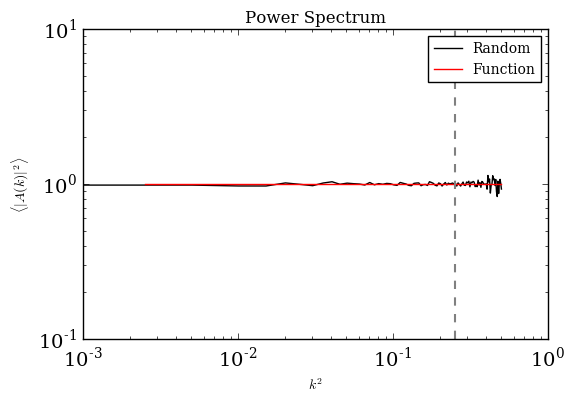

In [7]:
# We can also plot the power spectrum from the k-space distribution

def plot_power_spectrum(kx,ky,kA,func=None):
    ksq = kx**2 + ky**2

    bins = np.linspace(ksq.min(),ksq.max(),100)
    centers = (bins[1:]+bins[:-1])/2.
    labels = np.digitize(ksq,bins)

    # Take the complex conjugate of the k-space matrix
    kAsq = np.abs(kA)**2
    index = np.unique(labels)
    mean = nd.mean(kAsq.flatten(),labels=labels.flatten(),index=index)

    fig = plt.gcf(); ax = plt.gca()
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.plot(bins,mean,label='Random')
    if func is not None:
        ax.plot(centers,func(centers)**2,label='Function')
    ax.set_xlabel(r'$k^2$'); ax.set_ylabel(r'$ \langle |A(k)|^2 \rangle$')
    ax.set_title("Power Spectrum")
    ax.legend()
    
    plt.axvline(k0**2,ls='--',color='gray',lw=1.5)
    
plot_power_spectrum(kx,ky,kA,func)

Now we add the exponential suppression:

$p(k) = \mathcal{N} \times e^{i \phi} \times e^{-k^2/k_0^2}$

In [8]:
print "k0 = ",k0

# Create the random field in k-space
func = lambda ksq: np.exp(-ksq / k0 ** 2)
kA = rand*func(ksq)
xA = np.fft.ifft2(kA)

k0 =  0.5


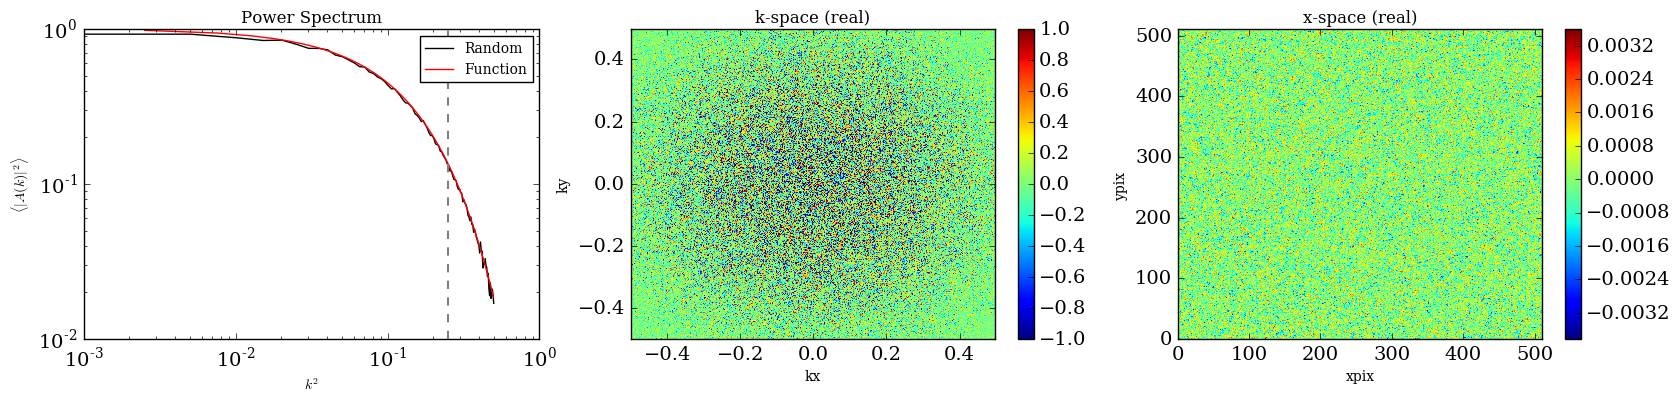

In [9]:
fig,ax = plt.subplots(1,3,figsize=(20,4))
plt.sca(ax[0]); plot_power_spectrum(kx,ky,kA,func)
plt.sca(ax[1]); plot_kspace(kx,ky,kA)
plt.sca(ax[2]); plot_xspace(xx,yy,xA)

Now we add the power-law suppression:

$p(k) = (\frac{k}{k_0})^\alpha \times \mathcal{N} \times e^{i \phi} \times e^{-k^2/k_0^2}$

In [10]:
print "kpow = ",kpow
print "alpha = ",2*kpow

m = ksq > 0
# Create the random field in k-space (need to be careful about zero now)
func = lambda ksq: (ksq/k0**2) ** kpow * np.exp(-ksq / k0 ** 2)

kA = np.zeros((n,n), complex)
kA[m] = rand[m] * func(ksq[m])

xA = np.fft.ifft2(kA)

kpow =  -0.75
alpha =  -1.5


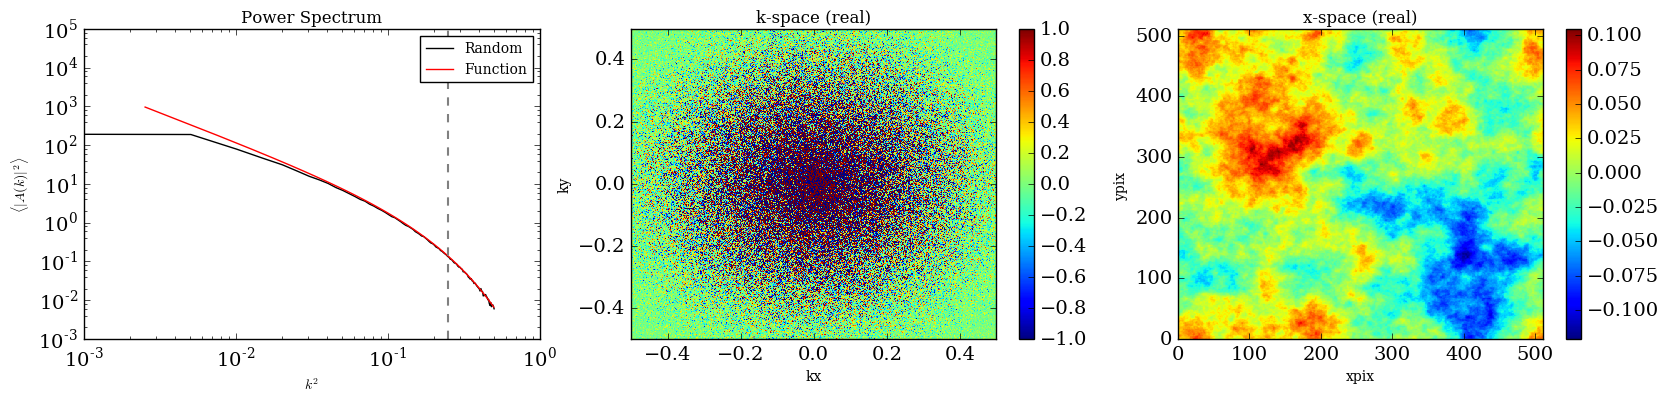

In [11]:
fig,ax = plt.subplots(1,3,figsize=(20,4))
plt.sca(ax[0]); plot_power_spectrum(kx,ky,kA,func)
plt.sca(ax[1]); plot_kspace(kx,ky,kA)
plt.sca(ax[2]); plot_xspace(xx,yy,xA)

# Packaging it up

So now we want to write a set of functions to package this all together. We would like to provide a function that that allows the user to easily control the physical scale of fluctuations, preferably on the more intuitive spatial correlation lenght (i.e., some $x_0$ rather than $k_0$). 

In [12]:
def kGRF(nx=512,ny=512,k0=0.1,alpha=-1.5, seed=123):
    """Modified from David Kirkby."""
    size = (nx,ny)

    kvx,kvy = np.fft.fftfreq(nx),np.fft.fftfreq(ny)
    kx,ky = np.meshgrid(kvy,kvx, sparse=True, copy=False)
    ksq = kx**2 + ky**2

    m = ksq > 0

    # Generate random numbers
    gen = np.random.RandomState(seed=seed)
    phase = 2 * np.pi * gen.uniform(size=size)
    norm = gen.normal(size=size)
    func = lambda ksq: (ksq/k0**2) ** (alpha/2.) * np.exp(-ksq / k0 ** 2)

    Ak = np.zeros(size,complex)
    Ak[m] = norm[m] * np.exp(1.j * phase[m]) * func(ksq[m])
    return kx,ky,Ak

kx,ky,Ak = kGRF(128,512)

In [13]:
def GRF(nx=512,ny=512,x0=8.0,alpha=-1.5):
    xx,yy = np.meshgrid(np.arange(nx),np.arange(ny), sparse=True, copy=False)
    k0 = np.sqrt(x0**2/float(nx*ny))
    kx,ky,Ak = kGRF(nx,ny,k0,alpha)
    Ax = np.fft.ifft2(Ak)
    return (kx,ky,Ak),(xx,yy,Ax)

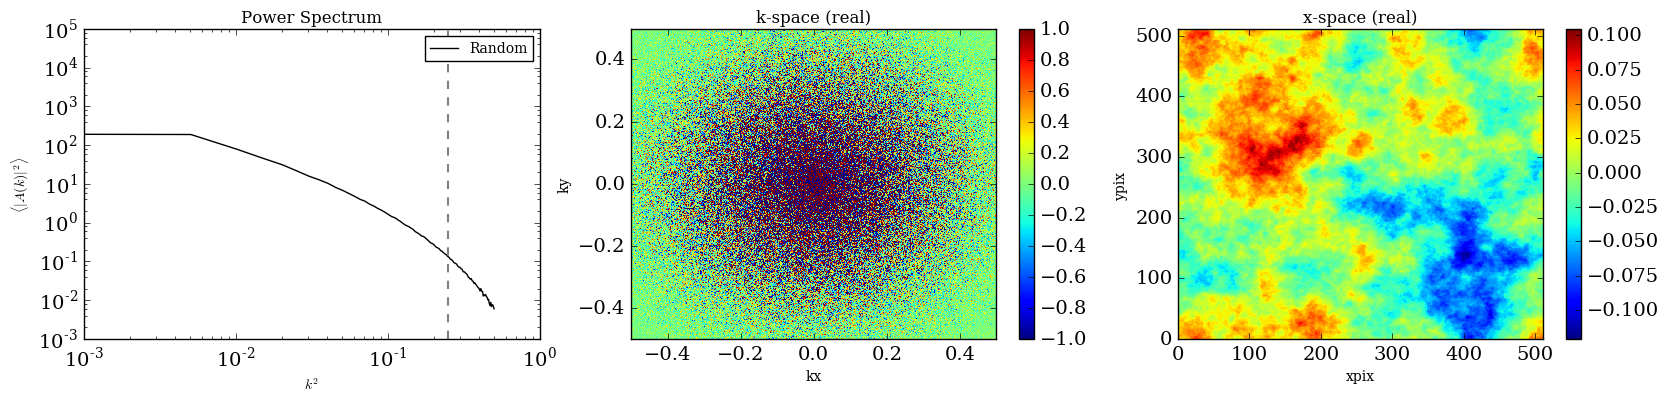

In [14]:
(kx,ky,Ak),(xx,yy,Ax) = GRF(x0=10)

fig,ax = plt.subplots(1,3,figsize=(20,4))
plt.sca(ax[0]); plot_power_spectrum(kx,ky,kA)
plt.sca(ax[1]); plot_kspace(kx,ky,kA)
plt.sca(ax[2]); plot_xspace(xx,yy,xA)

# Simulating Fringes

Now that we have the mechanism to produce two independent Gaussian random fields in position space (the real and imaginary components of Ax), we can use them as realizations of the two surfaces of a CCD. For long wavelengths, the CCD becomes semi-transparent, allowing waves to reflect off of the bottom of the CCD substrate and constructively/destructively interfere with themselves. This has the effect of creating fringes. Here we adapt some code by David Kirkby to simulate these fringes.

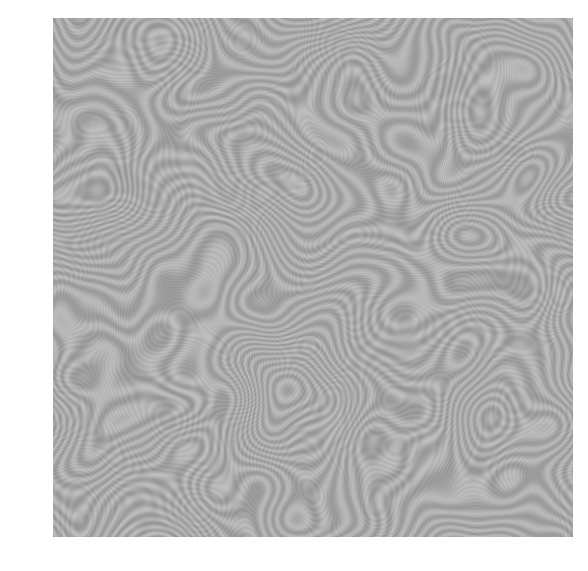

In [15]:
def simulate_fringes(n1=3.6, n2=1.5, amp1=0.02, amp2=0.05, nwaves_rms=10., seed=123, save=None):
    """Modified from David Kirkby."""

    (kx,ky,Ak), (xx,yy,Ax) = GRF(x0=8.0,alpha=-1.5)
    X = Ax
    X *= nwaves_rms / np.std(X.real)
    Z = amp1 * np.sin(2 * n1 * X.real) + amp2 * np.sin(2 * n2 * X.imag)

    vlim = np.max(np.abs(Z))

    fig = plt.figure(figsize=(6, 6))
    plt.imshow(Z, cmap='gray', vmin=-8*vlim, vmax=+4*vlim)
    plt.axis('off')
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

simulate_fringes()